## **Assignment 3: Stereo Vision** 

**Stereo Vision** refers to the technique of estimating depth and disparity from two slightly offset images taken from two cameras. In this assignment, we will be working with stereo images (left and right), and the goal is to compute the horizontal disparity (shift) of pixels along each scanline.

## Steps Overview:
**1. Block Matching:**
To compute the disparity map by comparing corresponding blocks of pixels in the left and right images

**2. Dynamic Programming:** To calculate the optimal matching of pixels along a scanline by minimizing the total cost of pixel matching and skipping

**3. Bonus Part: Alignment Plot** ; To plot the alignment of the matched scanlines

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

Loading Images (1st test case)

In [5]:
l1 = cv2.imread("assets/l1.png", cv2.IMREAD_GRAYSCALE)
r1 = cv2.imread("assets/r1.png", cv2.IMREAD_GRAYSCALE)

In [6]:
def display_image(image, title):
    plt.figure(figsize=(10, 5))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

def display_gray_image(image, title):
    plt.figure(figsize=(10, 5))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis("off")
    plt.show()

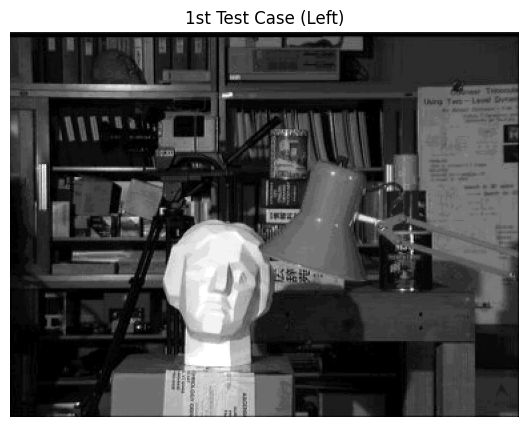

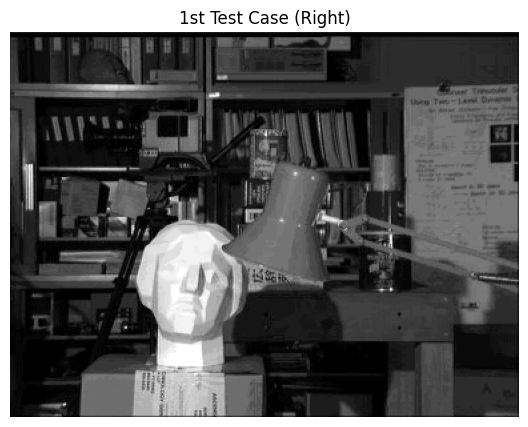

In [7]:
display_gray_image(l1, "1st Test Case (Left)")
display_gray_image(r1, "1st Test Case (Right)")

## 1.1.1 Block Matching

### Steps:
1. Load the left and right grayscale images.

2. For each pixel in the left image, extract a window (block) of pixels around it.

3. Search for the best matching window in the right image by comparing the left and right patches using Sum of Absolute Differences (SAD) or Sum of Squared Differences (SSD).

4. Compute the disparity by finding the horizontal shift that minimizes the chosen cost function.

5. Repeat for all pixels in the image to generate the disparity map.

6. Visualize the resulting disparity maps for different window sizes (1, 5, 9) and cost functions (SAD and SSD).

In [29]:
max_disparity = 64
window_sizes = [1, 5, 9]

In [30]:
def compute_disparity(left_img, right_img, max_disparity, window_size, method='SAD'):
    """
    Compute disparity map using block matching with either SAD or SSD.

    Parameters:
    - left_img: Left image (grayscale).
    - right_img: Right image (grayscale).
    - max_disparity: Maximum disparity shift.
    - window_size: Size of the matching window (odd number like 1, 5, 9).
    - method: 'SAD' or 'SSD'.

    Returns:
    - disparity_map: The computed disparity map.
    """
    h, w = left_img.shape
    disparity_map = np.zeros((h, w), dtype=np.float32)
    half_window = window_size // 2

    for y in range(half_window, h - half_window):
        for x in range(half_window, w - half_window):
            best_offset = 0
            min_cost = float('inf')

            left_patch = left_img[y - half_window:y + half_window + 1, x - half_window:x + half_window + 1]

            for d in range(0, max_disparity):
                if x - d - half_window < 0:
                    continue

                right_patch = right_img[y - half_window:y + half_window + 1, x - d - half_window:x - d + half_window + 1]

                if method == 'SAD':
                    cost = np.sum(np.abs(left_patch - right_patch))
                elif method == 'SSD':
                    cost = np.sum((left_patch - right_patch) ** 2)
                else:
                    raise ValueError("Method must be 'SAD' or 'SSD'")

                if cost < min_cost:
                    min_cost = cost
                    best_offset = d

            disparity_map[y, x] = best_offset

    return disparity_map


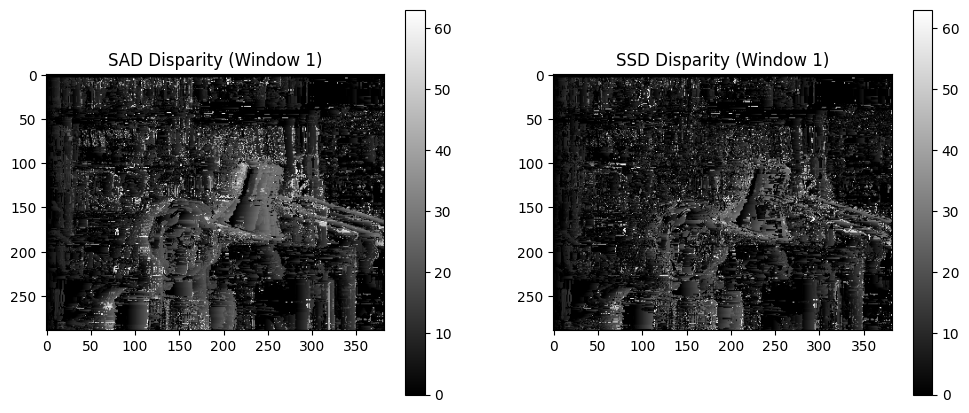

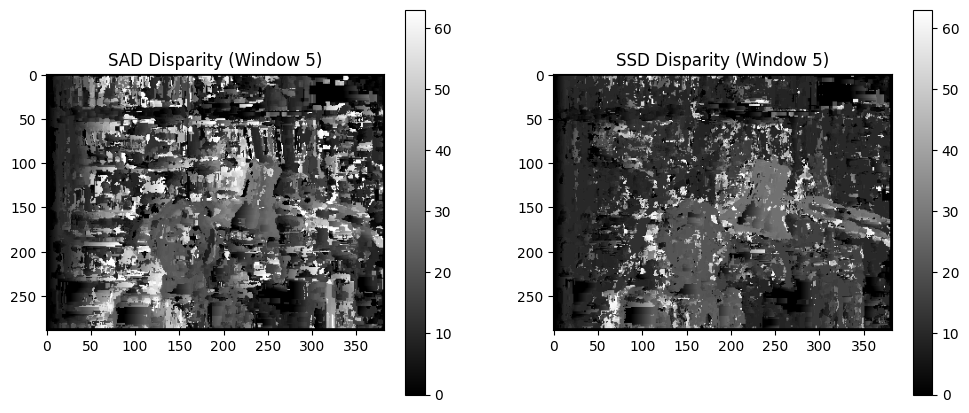

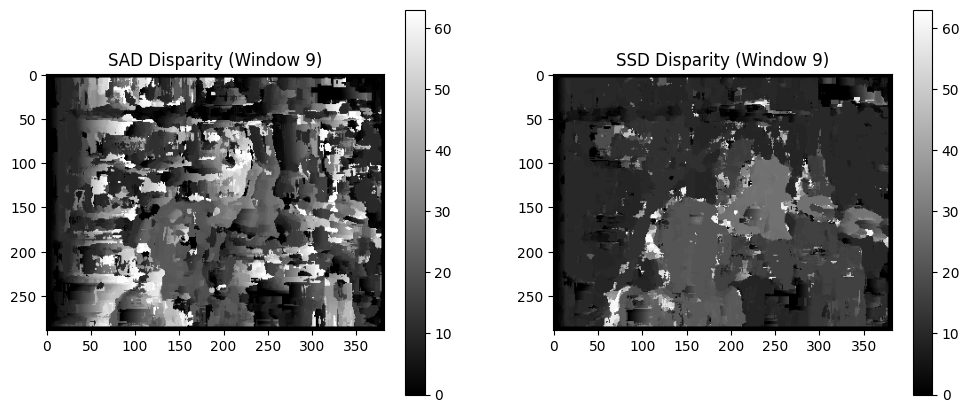

In [31]:
for w_size in window_sizes:
    disparity_sad = compute_disparity(l1, r1, max_disparity, w_size, method='SAD')
    disparity_ssd = compute_disparity(l1, r1, max_disparity, w_size, method='SSD')

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"SAD Disparity (Window {w_size})")
    plt.imshow(disparity_sad, cmap='gray')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title(f"SSD Disparity (Window {w_size})")
    plt.imshow(disparity_ssd, cmap='gray')
    plt.colorbar()

    plt.show()

In [ ]:
def block_matching(Il, Ir, window_size, method):
    h, w = Il.shape
    disparity_map = np.zeros((h, w), dtype=np.uint8)
    half = window_size // 2 
    max_disp = 64 #  try 128 (if too low, will miss correct matches, if too high will be slower)

    for y in range(half, h - half): # skipping edges due to window
        for x in range(half + max_disp, w - half):
            best_disparity = 0 
            min_cost = float("inf")
            for disp in range(max_disp):
                cost = 0
                for dy in range(-half, half + 1):
                    for dx in range(-half, half + 1):
                        l_val = int(Il[y + dy, x + dx])
                        r_val = int(Ir[y + dy, x + dx - disp])
                        if method == "SAD":
                            cost += abs(l_val - r_val)
                        else:
                            cost += (l_val - r_val) ** 2
                if cost < min_cost:
                    min_cost = cost
                    best_disparity = disp
            disparity_map[y, x] = best_disparity * 4 
    return disparity_map

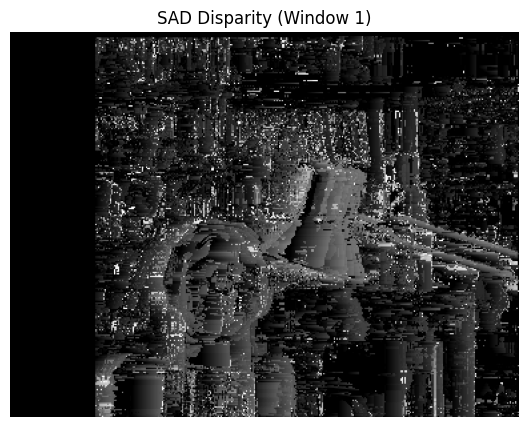

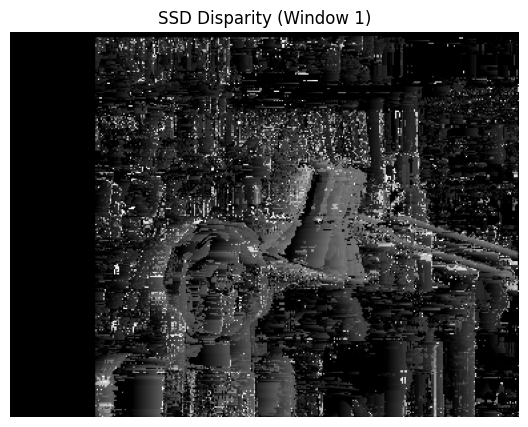

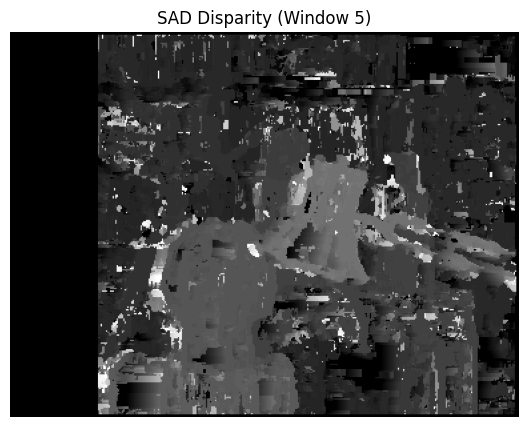

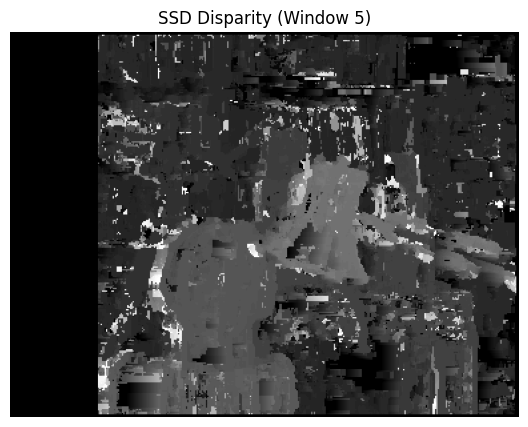

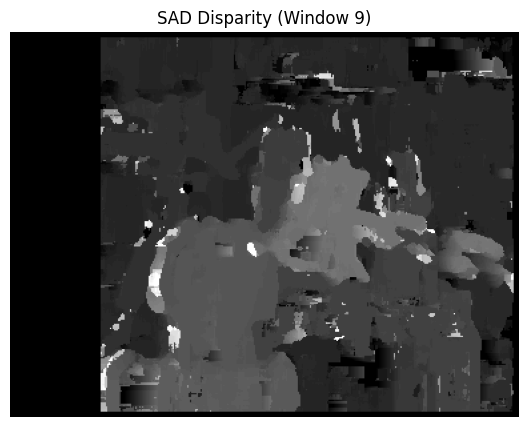

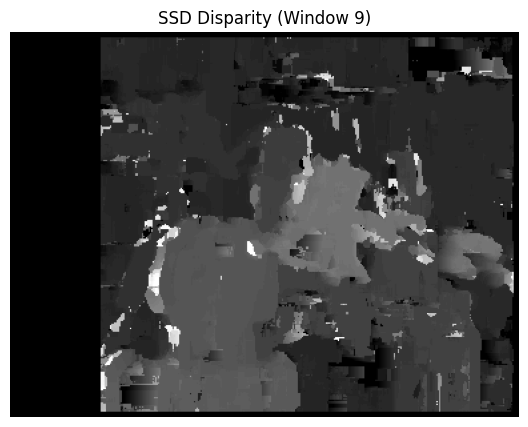

In [ ]:
for w in window_sizes:
    sad_map = block_matching(l1, r1, w, method="SAD")
    ssd_map = block_matching(l1, r1, w, method="SSD")
    cv2.imwrite(f"disparity_SAD_w{w}.png", sad_map)
    cv2.imwrite(f"disparity_SSD_w{w}.png", ssd_map)
    display_gray_image(sad_map, f"SAD Disparity (Window {w})")
    display_gray_image(ssd_map, f"SSD Disparity (Window {w})")

## 1.1.2 Dynamic Programming

### Steps:

1. Define the cost function to compute the difference between pixels in the left and right images using squared error.

2. Use dynamic programming to recursively compute the minimum cost of matching the scanlines by considering three possibilities: matching pixels, skipping a pixel in the left image, or skipping a pixel in the right image.

3. Store the computed costs in a 2D matrix, D.

4. Backtrack from the bottom-right corner of the matrix to the top-left to find the optimal alignment.

5. Visualize the alignment by plotting the paths of matched and skipped pixels.

In [19]:
def dynamic_programming(Il, Ir, sigma=2, c0=1):
    h, w = Il.shape
    disparity_map = np.zeros((h, w), dtype=np.uint8)

    for row in range(h):
        left = Il[row, :]
        right = Ir[row, :]
        n = len(left)
        D = np.zeros((n + 1, n + 1))
        D[0, :] = np.arange(n + 1) * c0
        D[:, 0] = np.arange(n + 1) * c0

        for i in range(1, n + 1):
            for j in range(1, n + 1):
                dij = ((int(left[i - 1]) - int(right[j - 1])) ** 2) / (sigma ** 2) # "dij = (Il(i) − Ir(j))² / σ²"
                D[i, j] = min( 
                    D[i - 1, j - 1] + dij,  # if match
                    D[i - 1, j] + c0,      #skip left
                    D[i, j - 1] + c0       #skip right
                )

        i, j = n, n
        # bakctracking to get optimal alignment
        while i > 0 and j > 0:
            if D[i, j] == D[i - 1, j - 1] + ((int(left[i - 1]) - int(right[j - 1])) ** 2) / (sigma ** 2): 
                disparity = abs(i - j) * 4
                disparity_map[row, i - 1] = min(disparity, 255)
                i -= 1
                j -= 1
            elif D[i, j] == D[i - 1, j] + c0:
                i -= 1
            else:
                j -= 1

    return disparity_map

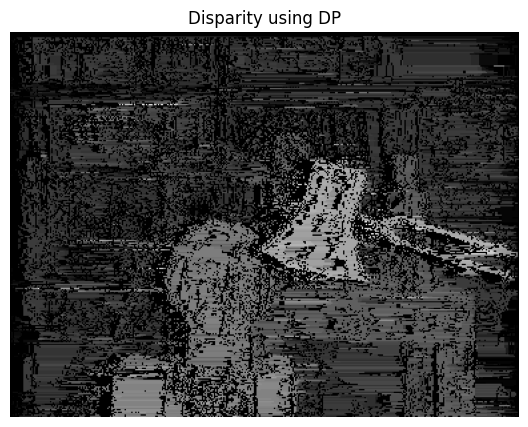

In [12]:
dp_map = dynamic_programming(l1, r1)
cv2.imwrite("disparity_dynamic.png", dp_map)
display_gray_image(dp_map, "Disparity using DP")

## 1.2 Bonus ; Plotting Alignment

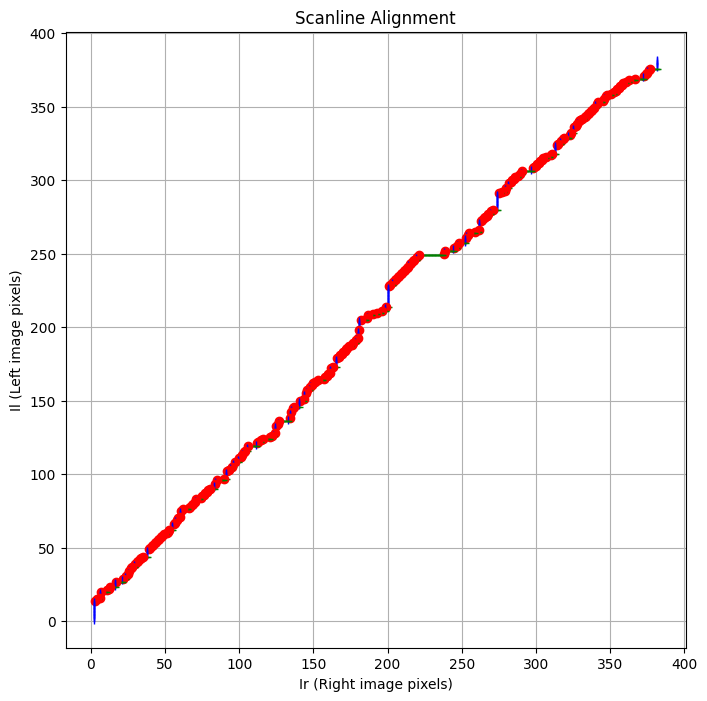

In [13]:
def plot_alignment(Il_row, Ir_row, sigma=2, c0=1):
    n = len(Il_row)
    D = np.zeros((n + 1, n + 1))
    D[0, :] = np.arange(n + 1) * c0
    D[:, 0] = np.arange(n + 1) * c0

    for i in range(1, n + 1):
        for j in range(1, n + 1):
            dij = ((int(Il_row[i - 1]) - int(Ir_row[j - 1])) ** 2) / (sigma ** 2)
            D[i, j] = min(
                D[i - 1, j - 1] + dij,
                D[i - 1, j] + c0,
                D[i, j - 1] + c0
            )

    i, j = n, n
    plt.figure(figsize=(8, 8))
    while i > 0 and j > 0:
        if D[i, j] == D[i - 1, j - 1] + ((int(Il_row[i - 1]) - int(Ir_row[j - 1])) ** 2) / (sigma ** 2):
            plt.plot(j, i, 'ro')  
            i -= 1
            j -= 1
        elif D[i, j] == D[i - 1, j] + c0:
            plt.plot(j, i, 'b|') 
            i -= 1
        else:
            plt.plot(j, i, 'g_') 
            j -= 1
    plt.xlabel("Ir (Right image pixels)")
    plt.ylabel("Il (Left image pixels)")
    plt.title("Scanline Alignment")
    plt.grid(True)
    plt.show()
    
plot_alignment(l1[100], r1[100])


--------------------------------------------

## Test Case 2

In [14]:
window_sizes = [1, 5]

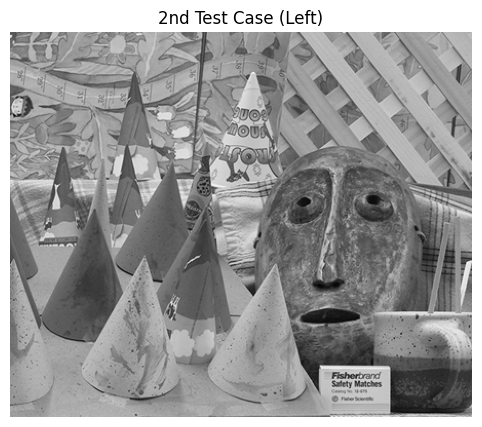

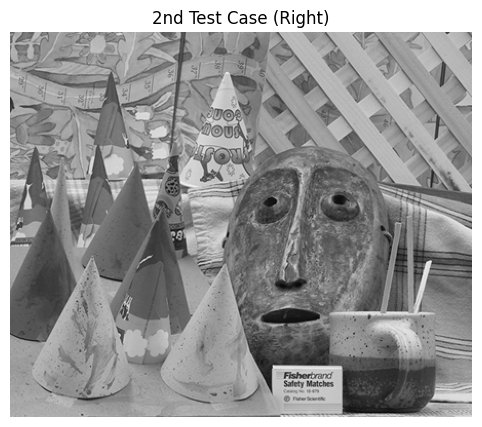

In [15]:
l2 = cv2.imread("assets/l2.png", cv2.IMREAD_GRAYSCALE)
r2 = cv2.imread("assets/r2.png", cv2.IMREAD_GRAYSCALE)

display_gray_image(l2, "2nd Test Case (Left)")
display_gray_image(r2, "2nd Test Case (Right)")

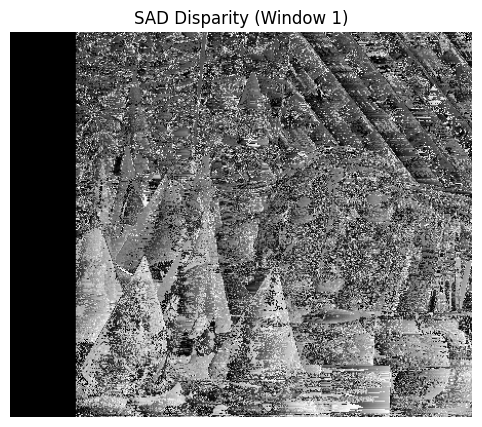

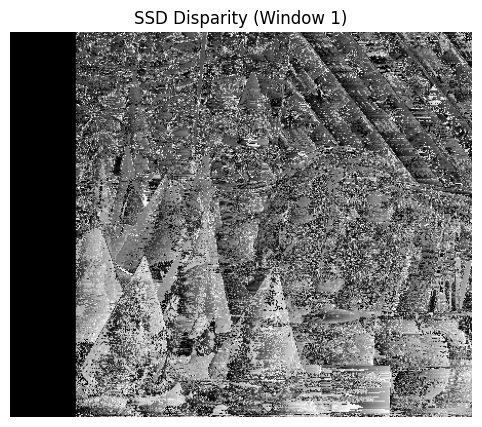

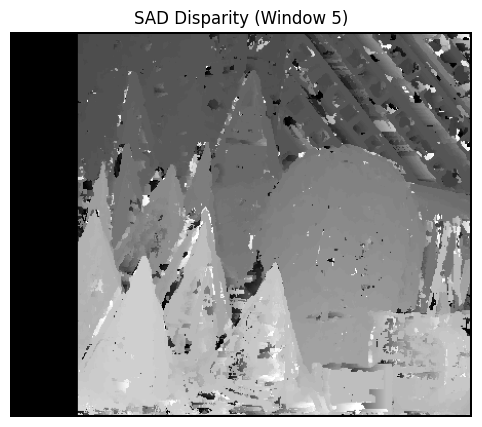

In [ ]:
for w in window_sizes:
    sad_map = block_matching(l2, r2, w, method="SAD")
    ssd_map = block_matching(l2, r2, w, method="SSD")
    cv2.imwrite(f"disparity2_SAD_w{w}.png", sad_map)
    cv2.imwrite(f"disparity2_SSD_w{w}.png", ssd_map)
    display_gray_image(sad_map, f"SAD Disparity (Window {w})")
    display_gray_image(ssd_map, f"SSD Disparity (Window {w})")

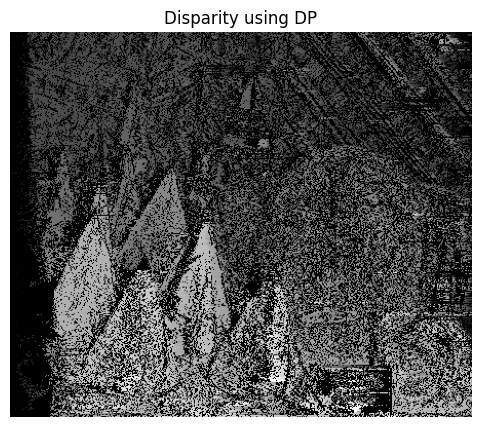

In [ ]:
dp_map = dynamic_programming(l2, r2)
cv2.imwrite("disparity2_dynamic.png", dp_map)
display_gray_image(dp_map, "Disparity using DP")

In [ ]:
scanline = 100 #ex
plot_alignment(l2[scanline], r2[scanline])

--------------------------------------------

## Test Case 3

In [22]:
window_sizes = [1, 5, 9]

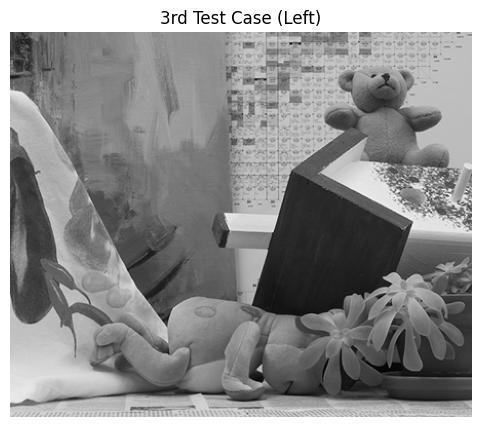

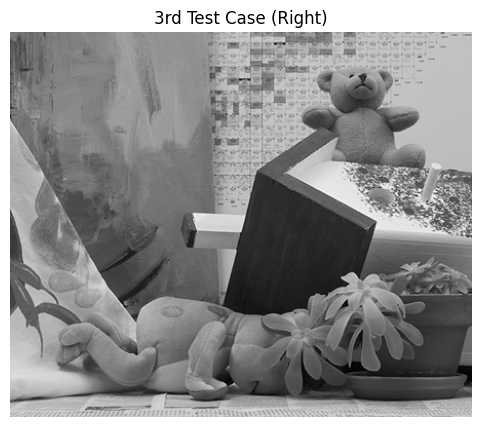

In [23]:
l3 = cv2.imread("assets/l3.png", cv2.IMREAD_GRAYSCALE)
r3 = cv2.imread("assets/r3.png", cv2.IMREAD_GRAYSCALE)

display_gray_image(l3, "3rd Test Case (Left)")
display_gray_image(r3, "3rd Test Case (Right)")

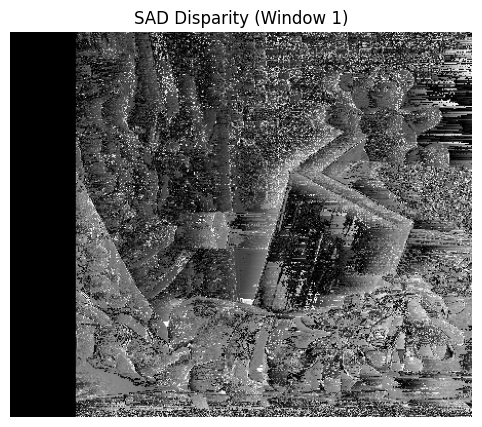

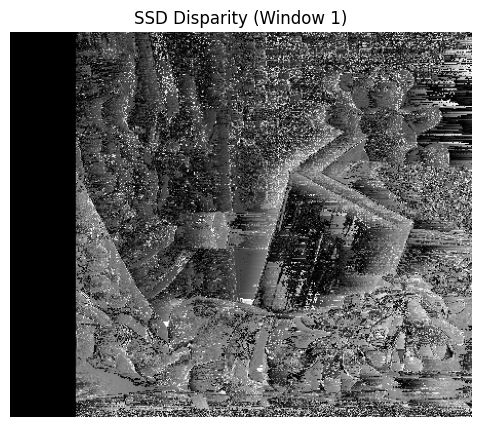

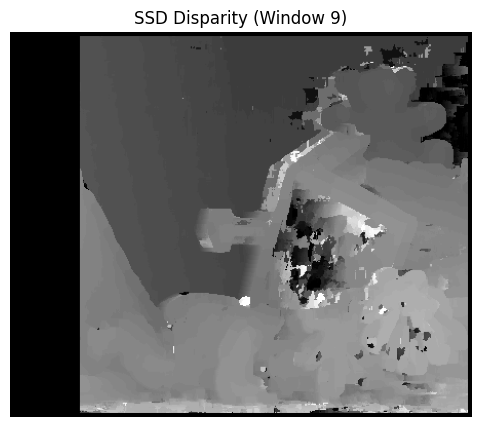

In [ ]:
for w in window_sizes:
    sad_map = block_matching(l3, r3, w, method="SAD")
    ssd_map = block_matching(l3, r3, w, method="SSD")
    cv2.imwrite(f"disparity3_SAD_w{w}.png", sad_map)
    cv2.imwrite(f"disparity3_SSD_w{w}.png", ssd_map)
    display_gray_image(sad_map, f"SAD Disparity (Window {w})")
    display_gray_image(ssd_map, f"SSD Disparity (Window {w})")

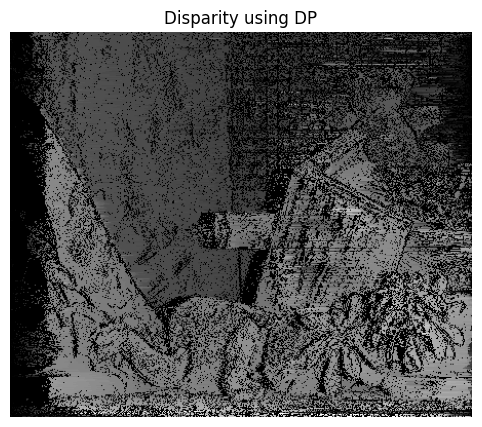

In [ ]:
dp_map = dynamic_programming(l3, r3)
cv2.imwrite("disparity3_dynamic.png", dp_map)
display_gray_image(dp_map, "Disparity using DP")

In [27]:
plot_alignment(l3[100], r3[100])